In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
from tsfresh import extract_relevant_features
in_file = 'C:/Users/nusra/Desktop/soleDataAnalysis/Tahsin_running2_1_min_bothsoles.json'
left = 'FDFWAG'
right = 'ESOIR7'
pd.options.display.max_rows=3000

In [ ]:
def get_data(type_of_data):
    from_file = pd.read_json(in_file)
    data_1 = from_file[left][type_of_data]
    data_2 = from_file[right][type_of_data]
    data_1 = pd.DataFrame(data_1).T
    data_1['name']=left
    data_2 = pd.DataFrame(data_2).T
    data_2['name']=right
    data = pd.concat([data_1,data_2])
    data = data.reset_index(level=0).rename(columns = {'index' : 'timestamp'})
    data['timestamp'].astype('int64')
    data = data.sort_values('timestamp', ascending=False)
    return data 
    
plt.rcParams["figure.figsize"] = (20,10)
accelerometer_data = get_data('AccelerometerData')
sensor_data = get_data('SensorReading')
sensor_data[['A','B','C','D']]*= 1
# sensor_data[sensor_data.name==right].plot(x='timestamp', y=['A'])
sensor_data = pd.merge(accelerometer_data, sensor_data, how='outer', on=['timestamp', 'timestamp'])
sensor_data['name']=sensor_data['name_y'].combine_first(sensor_data['name_x'])
sensor_data = sensor_data.drop(['name_y', 'name_x'], axis=1)
# sensor_data[sensor_data.name==right].sort_values('timestamp').plot(x='timestamp', y=['Ax','B'],c='DarkBlue')
sensor_data['label']='running'
# sensor_data = sensor_data.drop(['forefoot', 'heel','sole','varus'], axis=1)
# sensor_data[sensor_data.name==left]
# sensor_data = sensor_data.drop(['name'], axis=1)

sensor_data

In [ ]:
sensor_data = sensor_data.fillna(0) 
sensor_data

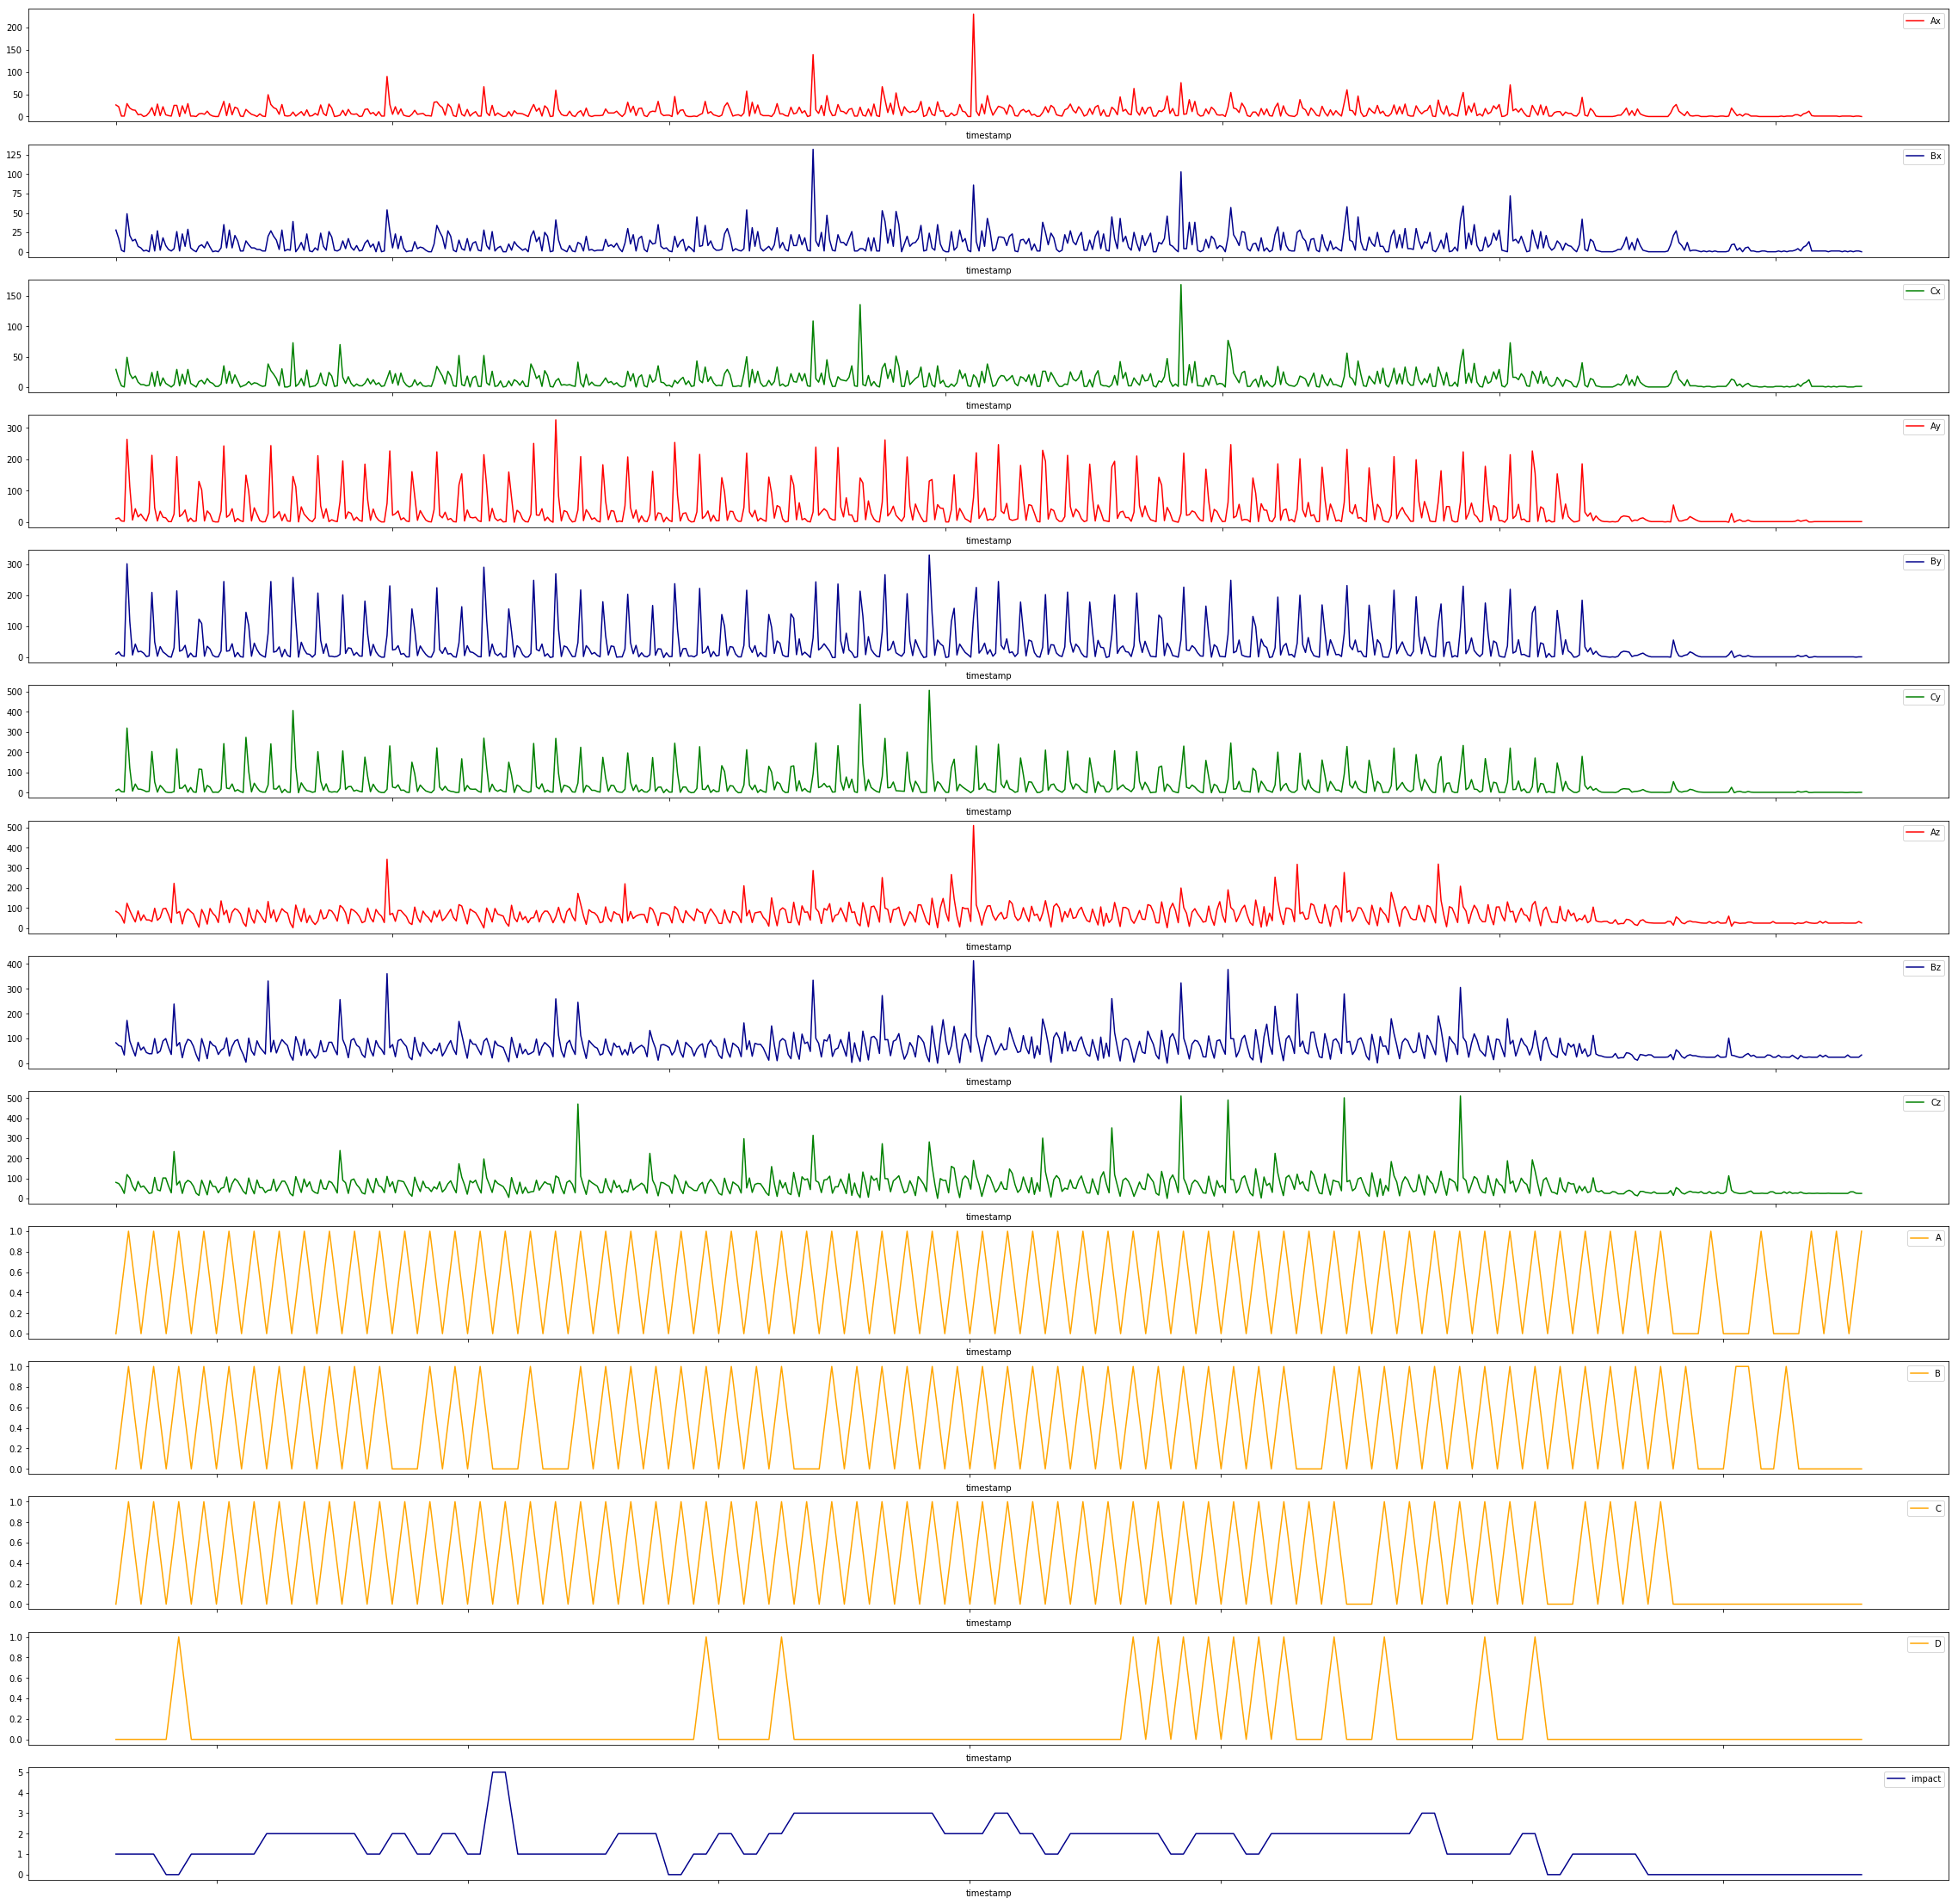

In [4]:
def plot_everything(shoe):
    fig, axes = plt.subplots(nrows=14, ncols=1,figsize=(40,40))
    sensor_data[sensor_data.name==shoe].plot(ax=axes[0],x='timestamp', y = 'Ax',c='red')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[1],x='timestamp', y='Bx',c='DarkBlue')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[2],x='timestamp', y='Cx',c='green')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[3],x='timestamp', y = 'Ay',c='red')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[4],x='timestamp', y='By',c='DarkBlue')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[5],x='timestamp', y='Cy',c='green')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[6],x='timestamp', y = 'Az',c='red')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[7],x='timestamp', y='Bz',c='DarkBlue')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[8],x='timestamp', y='Cz',c='green')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[9],x='timestamp', y='A',c='orange')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[10],x='timestamp', y='B',c='orange')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[11],x='timestamp', y='C',c='orange')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[12],x='timestamp', y='D',c='orange')
    sensor_data[sensor_data.name==shoe].plot(ax=axes[13],x='timestamp', y='impact',c='DarkBlue')
    
#     fig.savefig('tahsin_Eliptical2_bothsoles_35sec_right.png')
#     fig.savefig('tahsin_Eliptical2_bothsoles_35sec_left.png')
#     fig.savefig('nusrat_running2_1minutes_bothsoles_left.png')
#     fig.savefig('nusrat_running2_1minutes_bothsoles_right.png')
#     fig.savefig('Tahsin_running2_1_min_right.png')
#     fig.savefig('Tahsin_running2_1_min_left.png')
    fig.savefig('Tahsin_running2_1_min_right.png')


plot_everything(right)
# plot_everything(left)


In [5]:
sensor_data.to_csv('tahsin_Eliptical2_bothsoles_35sec.csv')

In [15]:
pd.__version__

'0.23.0'

In [2]:
pd.__version__

'0.23.0'

In [ ]:
# -*- coding: utf-8 -*-
# This file as well as the whole tsfresh package are licenced under the MIT licence (see the LICENCE.txt)
# Maximilian Christ (maximilianchrist.com), Blue Yonder Gmbh, 2016
"""
This module contains the main function to interact with tsfresh: extract features
"""

from __future__ import absolute_import, division

import logging
import sys
import warnings

import pandas as pd
import six

from tsfresh import defaults
from tsfresh.feature_extraction import feature_calculators
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh.utilities import dataframe_functions, profiling
from tsfresh.utilities.distribution import MapDistributor, MultiprocessingDistributor, DistributorBaseClass
from tsfresh.utilities.string_manipulation import convert_to_output_format

# todo: remove this call after we drop python 2.7 support
# From the description of https://docs.python.org/3/library/logging.html
# This function should be called from the main thread before other threads are started. In versions of Python prior
# to 2.7.1 and 3.2, if this function is called from multiple threads, it is possible (in rare circumstances) that a
# handler will be added to the root logger more than once, leading to unexpected results such as messages being
# duplicated in the log.
logging.basicConfig()


_logger = logging.getLogger(__name__)

if six.PY2:
    msg = "tsfresh versions 0.11.* will be the last ones to support python 2.7.*. From tsfresh versions 0.12.* on, " \
          "we will only support python 3.*. You are running python {}.{}.{}, please update.".format(
        sys.version_info.major, sys.version_info.minor, sys.version_info.micro)
    _logger.warning(msg)

def extract_features(timeseries_container, default_fc_parameters=None,
                     kind_to_fc_parameters=None,
                     column_id=None, column_sort=None, column_kind=None, column_value=None,
                     chunksize=defaults.CHUNKSIZE,
                     n_jobs=defaults.N_PROCESSES, show_warnings=defaults.SHOW_WARNINGS,
                     disable_progressbar=defaults.DISABLE_PROGRESSBAR,
                     impute_function=defaults.IMPUTE_FUNCTION,
                     profile=defaults.PROFILING,
                     profiling_filename=defaults.PROFILING_FILENAME,
                     profiling_sorting=defaults.PROFILING_SORTING,
                     distributor=None):
    """
    Extract features from

    * a :class:`pandas.DataFrame` containing the different time series

    or

    * a dictionary of :class:`pandas.DataFrame` each containing one type of time series

    In both cases a :class:`pandas.DataFrame` with the calculated features will be returned.

    For a list of all the calculated time series features, please see the
    :class:`~tsfresh.feature_extraction.settings.ComprehensiveFCParameters` class,
    which is used to control which features with which parameters are calculated.

    For a detailed explanation of the different parameters and data formats please see :ref:`data-formats-label`.

    Examples
    ========

    >>> from tsfresh.examples import load_robot_execution_failures
    >>> from tsfresh import extract_features
    >>> df, _ = load_robot_execution_failures()
    >>> X = extract_features(df, column_id='id', column_sort='time')

    :param timeseries_container: The pandas.DataFrame with the time series to compute the features for, or a
            dictionary of pandas.DataFrames.
    :type timeseries_container: pandas.DataFrame or dict

    :param default_fc_parameters: mapping from feature calculator names to parameters. Only those names
           which are keys in this dict will be calculated. See the class:`ComprehensiveFCParameters` for
           more information.
    :type default_fc_parameters: dict

    :param kind_to_fc_parameters: mapping from kind names to objects of the same type as the ones for
            default_fc_parameters. If you put a kind as a key here, the fc_parameters
            object (which is the value), will be used instead of the default_fc_parameters. This means that kinds, for
            which kind_of_fc_parameters doe not have any entries, will be ignored by the feature selection.
    :type kind_to_fc_parameters: dict

    :param column_id: The name of the id column to group by.
    :type column_id: str

    :param column_sort: The name of the sort column.
    :type column_sort: str

    :param column_kind: The name of the column keeping record on the kind of the value.
    :type column_kind: str

    :param column_value: The name for the column keeping the value itself.
    :type column_value: str

    :param n_jobs: The number of processes to use for parallelization. If zero, no parallelization is used.
    :type n_jobs: int

    :param chunksize: The size of one chunk that is submitted to the worker
        process for the parallelisation.  Where one chunk is defined as a
        singular time series for one id and one kind. If you set the chunksize
        to 10, then it means that one task is to calculate all features for 10
        time series.  If it is set it to None, depending on distributor,
        heuristics are used to find the optimal chunksize. If you get out of
        memory exceptions, you can try it with the dask distributor and a
        smaller chunksize.
    :type chunksize: None or int

    :param: show_warnings: Show warnings during the feature extraction (needed for debugging of calculators).
    :type show_warnings: bool

    :param disable_progressbar: Do not show a progressbar while doing the calculation.
    :type disable_progressbar: bool

    :param impute_function: None, if no imputing should happen or the function to call for imputing.
    :type impute_function: None or callable

    :param profile: Turn on profiling during feature extraction
    :type profile: bool

    :param profiling_sorting: How to sort the profiling results (see the documentation of the profiling package for
           more information)
    :type profiling_sorting: basestring

    :param profiling_filename: Where to save the profiling results.
    :type profiling_filename: basestring

    :param distributor: Advanced parameter: set this to a class name that you want to use as a
             distributor. See the utilities/distribution.py for more information. Leave to None, if you want
             TSFresh to choose the best distributor.
    :type distributor: class

    :return: The (maybe imputed) DataFrame containing extracted features.
    :rtype: pandas.DataFrame
    """

    # Always use the standardized way of storing the data.
    # See the function normalize_input_to_internal_representation for more information.
    df_melt, column_id, column_kind, column_value = \
        dataframe_functions._normalize_input_to_internal_representation(timeseries_container=timeseries_container,
                                                                        column_id=column_id, column_kind=column_kind,
                                                                        column_sort=column_sort,
                                                                        column_value=column_value)

    # Use the standard setting if the user did not supply ones himself.
    if default_fc_parameters is None and kind_to_fc_parameters is None:
        default_fc_parameters = ComprehensiveFCParameters()
    elif default_fc_parameters is None and kind_to_fc_parameters is not None:
        default_fc_parameters = {}

    # If requested, do profiling (advanced feature)
    if profile:
        profiler = profiling.start_profiling()

    with warnings.catch_warnings():
        if not show_warnings:
            warnings.simplefilter("ignore")
        else:
            warnings.simplefilter("default")

        result = _do_extraction(df=df_melt,
                                column_id=column_id, column_value=column_value, column_kind=column_kind,
                                n_jobs=n_jobs, chunk_size=chunksize,
                                disable_progressbar=disable_progressbar,
                                default_fc_parameters=default_fc_parameters,
                                kind_to_fc_parameters=kind_to_fc_parameters,
                                distributor=distributor)

        # Impute the result if requested
        if impute_function is not None:
            impute_function(result)

    # Turn off profiling if it was turned on
    if profile:
        profiling.end_profiling(profiler, filename=profiling_filename,
                                sorting=profiling_sorting)

    return result



def generate_data_chunk_format(df, column_id, column_kind, column_value):
    """Converts the dataframe df in into a list of individual time seriess.

    E.g. the DataFrame

        ====  ======  =========
          id  kind          val
        ====  ======  =========
           1  a       -0.21761
           1  a       -0.613667
           1  a       -2.07339
           2  b       -0.576254
           2  b       -1.21924
        ====  ======  =========

    into

        [(1, 'a', pd.Series([-0.217610, -0.613667, -2.073386]),
         (2, 'b', pd.Series([-0.576254, -1.219238])]


    The data is separated out into those single time series and the _do_extraction_on_chunk is
    called on each of them. The results are then combined into a single pandas DataFrame.

    The call is either happening in parallel or not and is showing a progress bar or not depending
    on the given flags.

    :param df: The dataframe in the normalized format which is used for extraction.
    :type df: pd.DataFrame

    :param column_id: The name of the id column to group by.
    :type column_id: str

    :param column_kind: The name of the column keeping record on the kind of the value.
    :type column_kind: str

    :param column_value: The name for the column keeping the value itself.
    :type column_value: str

    :return: the data in chunks
    :rtype: list
    """
    MAX_VALUES_GROUPBY = 2147483647

    if df[[column_id, column_kind]].nunique().prod() >= MAX_VALUES_GROUPBY:
        _logger.error(
            "The time series container has {} different ids and {} different kind of time series, in total {} possible combinations. "
            "Due to a limitation in pandas we can only process a maximum of {} id/kind combinations. Please reduce your time series container and restart "
            "the calculation".format(
                df[column_id].nunique(), df[column_kind].nunique(), df[[column_id, column_kind]].nunique().prod(), MAX_VALUES_GROUPBY)
        )
        raise ValueError("Number of ids/kinds are too high. Please reduce your data size and run feature extraction again.")
    data_in_chunks = [x + (y,) for x, y in df.set_index(column_id, drop=False).rename_axis(None).groupby([column_id, column_kind], as_index=True)[column_value]]
    return data_in_chunks



def _do_extraction(df, column_id, column_value, column_kind,
                   default_fc_parameters, kind_to_fc_parameters,
                   n_jobs, chunk_size, disable_progressbar, distributor):
    """
    Wrapper around the _do_extraction_on_chunk, which calls it on all chunks in the data frame.
    A chunk is a subset of the data, with a given kind and id - so a single time series.

    The data is separated out into those single time series and the _do_extraction_on_chunk is
    called on each of them. The results are then combined into a single pandas DataFrame.

    The call is either happening in parallel or not and is showing a progress bar or not depending
    on the given flags.

    :param df: The dataframe in the normalized format which is used for extraction.
    :type df: pd.DataFrame

    :param default_fc_parameters: mapping from feature calculator names to parameters. Only those names
           which are keys in this dict will be calculated. See the class:`ComprehensiveFCParameters` for
           more information.
    :type default_fc_parameters: dict

    :param kind_to_fc_parameters: mapping from kind names to objects of the same type as the ones for
            default_fc_parameters. If you put a kind as a key here, the fc_parameters
            object (which is the value), will be used instead of the default_fc_parameters.
    :type kind_to_fc_parameters: dict

    :param column_id: The name of the id column to group by.
    :type column_id: str

    :param column_kind: The name of the column keeping record on the kind of the value.
    :type column_kind: str

    :param column_value: The name for the column keeping the value itself.
    :type column_value: str

    :param chunk_size: The size of one chunk for the parallelization
    :type chunk_size: None or int

    :param n_jobs: The number of processes to use for parallelization. If zero, no parallelization is used.
    :type n_jobs: int

    :param disable_progressbar: Do not show a progressbar while doing the calculation.
    :type disable_progressbar: bool

    :param distributor: Advanced parameter:  See the utilities/distribution.py for more information.
                         Leave to None, if you want TSFresh to choose the best distributor.
    :type distributor: DistributorBaseClass

    :return: the extracted features
    :rtype: pd.DataFrame
    """

    data_in_chunks = generate_data_chunk_format(df, column_id, column_kind, column_value)

    if distributor is None:
        if n_jobs == 0:
            distributor = MapDistributor(disable_progressbar=disable_progressbar,
                                         progressbar_title="Feature Extraction")
        else:
            distributor = MultiprocessingDistributor(n_workers=n_jobs, disable_progressbar=disable_progressbar,
                                                     progressbar_title="Feature Extraction")

    if not isinstance(distributor, DistributorBaseClass):
        raise ValueError("the passed distributor is not an DistributorBaseClass object")

    kwargs = dict(default_fc_parameters=default_fc_parameters, kind_to_fc_parameters=kind_to_fc_parameters)
    result = distributor.map_reduce(_do_extraction_on_chunk, data=data_in_chunks, chunk_size=chunk_size,
                                    function_kwargs=kwargs)
    distributor.close()

    # Return a dataframe in the typical form (id as index and feature names as columns)
    result = pd.DataFrame(result)
    if result.columns.contains("value"):
        result["value"] = result["value"].astype(float)

    if len(result) != 0:
        result = result.pivot("id", "variable", "value")
        result.index = result.index.astype(df[column_id].dtype)

    return result


def _do_extraction_on_chunk(chunk, default_fc_parameters, kind_to_fc_parameters):
    """
    Main function of this module: use the feature calculators defined in the
    default_fc_parameters or kind_to_fc_parameters parameters and extract all
    features on the chunk.

    The chunk consists of the chunk id, the chunk kind and the data (as a Series),
    which is then converted to a numpy array - so a single time series.

    Returned is a list of the extracted features. Each one is a dictionary consisting of
    { "variable": the feature name in the format <kind>__<feature>__<parameters>,
      "value": the number value of the feature,
      "id": the id of the chunk }

    The <parameters> are in the form described in :mod:`~tsfresh.utilities.string_manipulation`.

    :param chunk: A tuple of sample_id, kind, data
    :param default_fc_parameters: A dictionary of feature calculators.
    :param kind_to_fc_parameters: A dictionary of fc_parameters for special kinds or None.
    :return: A list of calculated features.
    """
    sample_id, kind, data = chunk
    data = data.values

    if kind_to_fc_parameters and kind in kind_to_fc_parameters:
        fc_parameters = kind_to_fc_parameters[kind]
    else:
        fc_parameters = default_fc_parameters

    def _f():
        for function_name, parameter_list in fc_parameters.items():
            func = getattr(feature_calculators, function_name)

            if func.fctype == "combiner":
                result = func(data, param=parameter_list)
            else:
                if parameter_list:
                    result = ((convert_to_output_format(param), func(data, **param)) for param in parameter_list)
                else:
                    result = [("", func(data))]

            for key, item in result:
                feature_name = str(kind) + "__" + func.__name__
                if key:
                    feature_name += "__" + str(key)
                yield {"variable": feature_name, "value": item, "id": sample_id}

    return list(_f())

In [ ]:
extracted_features = extract_features(sensor_data, column_id='Ax', column_sort="timestamp", chunksize = 200)
extracted_features